In [2]:
import src.explainers as exp
import matplotlib.pyplot as plt

In [22]:
import importlib
importlib.reload(exp)

<module 'src.explainers' from '/home/mikesmac/Documents/GraphSVX/src/explainers.py'>

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data

dataset = Planetoid(root='/tmp/Cora', name='Cora')
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Processing...
Done!


In [4]:
x = dataset[0].x[:,:64].cuda()
edge_index = dataset[0].edge_index.cuda()
y = dataset[0].y.cuda()

In [5]:
y = torch.rand(y.shape[0], 1).cuda()

In [6]:
data = dataset[0]
data = Data(x=x, y=y, edge_index=edge_index).cuda()


In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(64, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data = data.to(device)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()

In [25]:
data.num_classes = 1
# e = exp.GraphSVX(data.cpu(), model, gpu=True)
# shap_values_10 = e.explain(node_indexes=[0], info=False, num_samples=10, multiclass=False, args_feat='All', target_type='reg')
# e = exp.GraphSVX(data.cpu(), model, gpu=True)
# shap_values_100 = e.explain(node_indexes=[0], info=False, num_samples=100, multiclass=False, args_feat='All', target_type='reg')
e = exp.GraphSVX(data.cpu(), model, gpu=True)
shap_values_100 = e.explain(node_indexes=[2], info=True, num_samples=100, multiclass=False, args_feat='All', target_type='reg')
#e = exp.GraphSVX(data.cpu(), model, gpu=True)
#shap_values_3000 = e.explain(node_indexes=[0], info=False, num_samples=3000, multiclass=False, args_feat='All', target_type='reg')

100it [00:00, 250.54it/s]

WLS: Matrix not invertible
r2:  -0.9324820364127149
weighted r2:  0.9998772558892514
Explanations include 64 node features and 79 neighbours for this node            
Model prediction is tensor([0.4759], device='cuda:0'), while true target is tensor([0.4031])
Base value 0.47871894233730217 for class  0.4759063422679901
Weights for node features:  -0.001482096618929063 and neighbours:  -0.001337371959380107
Most influential features:  2 and neighbours 4
Most influential features:  [(3, -0.010162353515625), (39, 0.0034936387710331473), (6, 0.0016153733304236084)]
Most influential neighbours:  [(332, -0.018128395080566406), (1, 0.006040170077540097), (1986, 0.003714534432219807)]
Time:  0.5902400016784668


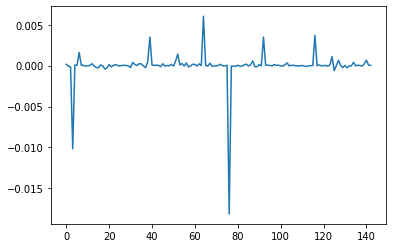

In [26]:
plt.plot(shap_values_100[0])